In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
_x_mcmc = np.concatenate((
    np.loadtxt('../base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE_1.txt')[:,2:11],
    np.loadtxt('../base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE_2.txt')[:,2:11],
    np.loadtxt('../base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE_3.txt')[:,2:11],
    np.loadtxt('../base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE_4.txt')[:,2:11]))
_p_mcmc = np.concatenate((
    np.loadtxt('../base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE_1.txt')[:,0],
    np.loadtxt('../base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE_2.txt')[:,0],
    np.loadtxt('../base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE_3.txt')[:,0],
    np.loadtxt('../base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE_4.txt')[:,0]))

In [2]:
import numpy as np
para_range = np.array(((0.005, 0.1),
                       (0.001, 0.99),
                       (0.5, 10),
                       (0.01, 0.8),
                       (0, 3),
                       (3.046, 10),
                       (1.61, 3.91),
                       (0.8, 1.2),
                       (0.9, 1.1)))
init_mu = np.array((0.0221, 0.12, 1.0411, 0.06, 0.1, 3.1, 3.1, 0.96, 1.))
init_sig = (para_range[:, 1] - para_range[:, 0]) / 1000
sterile_mphys_max = 10

In [3]:
def stratified_resample_1(logq, n, a=1, b=100):
    logq = np.asarray(logq).flatten()
    m = logq.size
    i_finite = np.arange(m)[np.isfinite(logq)]
    logq = logq[np.isfinite(logq)].copy()
    mf = logq.size
    
    _a = int(mf * a / 100 - 1)
    _b = int(mf * b / 100 - 1)
    
    i = np.linspace(_a, _b, n).astype(np.int)
    return i_finite[np.argsort(logq)[i]]

def stratified_resample_2(logq, n, a=1, b=20, c=100, f=0.8):
    logq = np.asarray(logq).flatten()
    m = logq.size
    i_finite = np.arange(m)[np.isfinite(logq)]
    logq = logq[np.isfinite(logq)].copy()
    mf = logq.size
    
    _a = int(mf * a / 100 - 1)
    _b = int(mf * b / 100 - 1)
    _c = int(mf * c / 100 - 1)
    
    n_1 = int(f * n)
    n_2 = n - n_1
    i = np.concatenate((np.linspace(_a, _b, n_1), 
                        np.linspace(_b, _c, n_2 + 1)[1:])).astype(np.int)
    return i_finite[np.argsort(logq)[i]]

In [4]:
import sobol_seq
xx_plot_0 = sobol_seq.i4_sobol_generate_std_normal(9, 10000) * init_sig + init_mu
def _in_bound(xx, bound):
    xxt = np.atleast_2d(xx).T
    return np.product([np.where(xi>bound[i,0], True, False) * 
                       np.where(xi<bound[i,1], True, False) for i, xi in enumerate(xxt)], axis=0).astype(bool)
xx_plot_0 = xx_plot_0[_in_bound(xx_plot_0, para_range)]
xx_0 = xx_plot_0[:18]

In [5]:
import sys
sys.path.append('/global/homes/h/hejia/BayesFast/dev/')
from cosmofast.planck2018._simall import _simall_f, _simall_j, _simall_fj
from cosmofast.planck2018._plik_lite_diag import _plik_lite_f, _plik_lite_j, _plik_lite_fj, _get_binned_cls
from cosmofast.planck2018._commander import _commander_f, _commander_j, _commander_fj

In [6]:
from scipy.io import FortranFile
cov_low_plik = FortranFile('/global/u2/h/hejia/Planck/2018/baseline/plc_3.0/hi_l/plik_lite/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/c_matrix_plik_v22.dat').read_reals().reshape((613,613))
cov_plik = cov_low_plik + cov_low_plik.T - np.diag(np.diag(cov_low_plik))
X_data_plik = np.loadtxt('/global/u2/h/hejia/Planck/2018/baseline/plc_3.0/hi_l/plik_lite/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v22.dat')[:, 1].copy()
blmin_plik = np.loadtxt('/global/u2/h/hejia/Planck/2018/baseline/plc_3.0/hi_l/plik_lite/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/blmin.dat')
blmax_plik = np.loadtxt('/global/u2/h/hejia/Planck/2018/baseline/plc_3.0/hi_l/plik_lite/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/blmax.dat')
bweight_plik = np.loadtxt('/global/u2/h/hejia/Planck/2018/baseline/plc_3.0/hi_l/plik_lite/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/bweight.dat')
bwt_plik = np.copy(bweight_plik[int(blmin_plik[0]):int(blmax_plik[214] + 1)])
bwe_plik = np.copy(bweight_plik[int(blmin_plik[0]):int(blmax_plik[198] + 1)])
cov_inv_plik = np.linalg.inv(cov_plik)
_bin_mt_plik = np.copy(blmin_plik[:215]).astype(np.int32)
_bin_wt_plik = np.copy((blmax_plik - blmin_plik + 1)[:215]).astype(np.int32)
_bin_me_plik = np.copy(blmin_plik[:199]).astype(np.int32)
_bin_we_plik = np.copy((blmax_plik - blmin_plik + 1)[:199]).astype(np.int32)
cov_inv_plik_l = np.linalg.cholesky(cov_inv_plik)
X_data_plik_l = X_data_plik @ cov_inv_plik_l

In [7]:
import camb

def bnm_model(xx, concatenate=True):
    import os
    os.environ['OMP_NUM_THREADS'] = '1'
    pars = camb.CAMBparams(WantDerivedParameters=False, Want_cl_2D_array=False, Want_CMB_lensing=False, min_l=1, max_l=2508)
    pars.set_cosmology(cosmomc_theta=xx[2]/100, ombh2=xx[0], omch2=xx[1], tau=xx[3], meffsterile=xx[4], nnu=xx[5])
    pars.InitPower.set_params(As=np.exp(xx[6])*1e-10, ns=xx[7])
    pars.set_for_lmax(2508, lens_potential_accuracy=0)
    power = camb.get_results(pars).get_cmb_power_spectra(pars, CMB_unit='muK', lmax=2508, spectra=['lensed_scalar',], raw_cl=True)['lensed_scalar']
    cls_b = np.empty(613)
    _get_binned_cls(power[30:, 0].copy(), cls_b[:215], bwt_plik, _bin_mt_plik, _bin_wt_plik, 215)
    _get_binned_cls(power[30:, 3].copy(), cls_b[215:414], bwe_plik, _bin_me_plik, _bin_we_plik, 199)
    _get_binned_cls(power[30:, 1].copy(), cls_b[414:613], bwe_plik, _bin_me_plik, _bin_we_plik, 199)
    if concatenate:
        res = np.concatenate((power[2:30, 0], power[2:30, 1], cls_b @ cov_inv_plik_l))
        return res
    else:
        return power[2:30, 0].copy(), power[2:30, 1].copy(), cls_b @ cov_inv_plik_l

In [8]:
from astropy.io import fits
ff = fits.open('/global/u2/h/hejia/Planck/2018/baseline/plc_3.0/low_l/commander/commander_dx12_v3_2_29.clik/clik/lkl_0/_external/sigma.fits')
cl2x_com = np.ascontiguousarray(np.moveaxis(ff[0].data.T[:, :28, :], 0, 2)).byteswap().newbyteorder()
mu_com = ff[1].data[:28].byteswap().newbyteorder()
cov_com = ff[2].data[:28, :28].byteswap().newbyteorder()
mu_sig_com = ff[3].data[:28].byteswap().newbyteorder()
cov_inv_com = np.linalg.inv(cov_com)

In [9]:
out_f = np.empty(1)
_commander_f(mu_sig_com * 2 * np.pi / np.arange(2, 30) / (np.arange(2, 30) + 1), 1.0, out_f, cl2x_com, mu_com, cov_inv_com)
zero_com = float(out_f)

In [10]:
ffB_simall = fits.open('/global/u2/h/hejia/Planck/2018/baseline/plc_3.0/low_l/simall/simall_100x143_offlike5_EEBB_Aplanck_B.clik/clik/lkl_0/probBB')
ffE_simall = fits.open('/global/u2/h/hejia/Planck/2018/baseline/plc_3.0/low_l/simall/simall_100x143_offlike5_EEBB_Aplanck_B.clik/clik/lkl_0/probEE')
from scipy.interpolate import CubicSpline
cc = CubicSpline(np.arange(0, 0.0001*3000, 0.0001), ffE_simall[0].data.reshape((28, 3000)), axis=1)
_cc_ = np.swapaxes(cc.c, 0, 2).copy()

In [11]:
def planck_like_f(xx, cal, cosmo):
    out_f = np.zeros(1)
    _out_f = np.empty(1)
    _commander_f(xx[:28], float(cal), _out_f, cl2x_com, mu_com, cov_inv_com)
    out_f += _out_f - zero_com
    _simall_f(xx[28:56], float(cal), _out_f, _cc_, 0.0001, 3000)
    out_f += _out_f
    _plik_lite_f(xx[56:669], float(cal), _out_f, X_data_plik_l, 613)
    out_f += _out_f
    
    mu_y = 1
    sig_y = 0.0025
    out_f[0] -= (cal-mu_y)**2/(2*sig_y**2) + 0.5*np.log(2*np.pi*sig_y**2)
    
    if cosmo[4] / (cosmo[5] - 3.046)**0.75 > sterile_mphys_max:
        out_f[0] -= 10000.
    
    return out_f

In [12]:
def planck_like_fj(xx, cal, cosmo):
    out_f = np.zeros(1)
    out_j = np.zeros((1, 670))
    
    _out_f = np.empty(1)
    _out_j = np.empty((1, 29))
    _commander_fj(xx[:28], float(cal), _out_f, _out_j, cl2x_com, mu_com, cov_inv_com)
    out_f += _out_f - zero_com
    out_j[0, :28] += _out_j[0, :28]
    out_j[0, -1] += _out_j[0, -1]
    
    _out_j = np.empty((1, 29))
    _simall_fj(xx[28:56], float(cal), _out_f, _out_j, _cc_, 0.0001, 3000)
    out_f += _out_f
    out_j[0, 28:56] += _out_j[0, :28]
    out_j[0, -1] += _out_j[0, -1]
    
    _out_j = np.empty((1, 614))
    _plik_lite_fj(xx[56:669], float(cal), _out_f, _out_j, X_data_plik_l, 613)
    out_f += _out_f
    out_j[0, 56:670] += _out_j[0]
    
    mu_y = 1
    sig_y = 0.0025
    out_f[0] -= (cal-mu_y)**2/(2*sig_y*sig_y) + 0.5*np.log(2*np.pi*sig_y*sig_y)
    out_j[0, -1] -= (cal-mu_y)/(sig_y*sig_y)
    
    if cosmo[4] / (cosmo[5] - 3.046)**0.75 > sterile_mphys_max:
        out_f[0] -= 1000.
    
    return out_f, np.concatenate((out_j, np.zeros((1, 8))), axis=1)

In [13]:
from bayesfast.density import *
from bayesfast.module import *
from bayesfast.modules.poly import *

In [14]:
m1 = Module(fun=lambda xx: bnm_model(xx, True), 
            input_names=['cosmology'],
            output_names=['power'])

In [15]:
m2 = Module(fun=planck_like_f, 
            fun_and_jac=planck_like_fj,
            input_names=['power', 'cal', 'cosmology'],
            output_names=['logp'],
            concatenate_input=False)

In [16]:
m3 = PolyModel(PolyConfig('linear', np.arange(8), np.arange(669)), 
               SurrogateIndices(0, 1), 8, 669, 
               input_names=['cosmology'], output_names=['power'])

In [17]:
'''import multiprocessing as mp
pool = mp.Pool(24)
yy_0 = np.array(pool.map(bnm_model, xx_0))
pool.close()
pool.join()'''
import sharedmem
with sharedmem.MapReduce(np=18) as pool:
    yy_0 = np.array(pool.map(bnm_model, xx_0))

In [18]:
m3.fit(xx_0[:, :8], yy_0)

In [19]:
m2(m3(xx_0[0, :-1]), xx_0[0, -1], xx_0[0, :-1])

array([-953.12691171])

In [20]:
m2(yy_0[0], xx_0[0, -1], xx_0[0, :-1])

array([-955.73484148])

In [21]:
den = Density('logp', [m1, m2], ['cosmology', 'cal'], [8, 1], m3, para_range,
              True, True)

In [22]:
xx_ref_0 = den.from_original(xx_0[0], False)

In [23]:
from scipy.optimize import minimize
from numdifftools import Gradient, Hessian
opt0 = minimize(lambda xx: -den(xx, True, False), xx_ref_0, method='Newton-CG', 
                jac=lambda xx: -den.grad(xx, True, False),
                hess=Hessian(lambda xx: -den(xx, True, False)))

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged 

In [24]:
opt0.success

True

In [25]:
den(opt0.x, False, False)

-520.6165035009687

In [26]:
den(opt0.x, True, False)

-515.0575096782982

In [27]:
from scipy.linalg import sqrtm
xx_ref_1 = opt0.x
cov_1 = np.linalg.inv(Hessian(lambda xx: -den(xx, True, False))(xx_ref_1))
cov_1 = sqrtm(cov_1 @ cov_1)

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))


In [28]:
xx_1 = den.to_original(sobol_seq.i4_sobol_generate_std_normal(9, 18) @ sqrtm(cov_1) / 5 + xx_ref_1)
xx_plot_1 = den.to_original(sobol_seq.i4_sobol_generate_std_normal(9, 1000) @ sqrtm(cov_1) / 5 + xx_ref_1)

In [29]:
import sharedmem
with sharedmem.MapReduce(np=18) as pool:
    yy_1 = np.array(pool.map(bnm_model, xx_1))

In [30]:
m3.fit(xx_1[:, :8], yy_1)

In [31]:
from scipy.optimize import minimize
from numdifftools import Gradient, Hessian
opt1 = minimize(lambda xx: -den(xx, True, False), xx_ref_1, method='Newton-CG', 
                jac=lambda xx: -den.grad(xx, True, False),
                hess=Hessian(lambda xx: -den(xx, True, False)))

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged 

In [32]:
opt1.success

True

In [33]:
den(opt1.x, False, False)

-518.9817230788458

In [34]:
den(opt1.x, True, False)

-518.6814905037322

In [35]:
from scipy.linalg import sqrtm
xx_ref_2 = opt1.x
cov_2 = np.linalg.inv(Hessian(lambda xx: -den(xx, True, False))(xx_ref_2))
cov_2 = sqrtm(cov_2 @ cov_2)

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))


In [36]:
xx_2 = den.to_original(sobol_seq.i4_sobol_generate_std_normal(9, 18) @ sqrtm(cov_2) / 5 + xx_ref_2)
xx_plot_2 = den.to_original(sobol_seq.i4_sobol_generate_std_normal(9, 1000) @ sqrtm(cov_2) / 5 + xx_ref_2)

In [37]:
import sharedmem
with sharedmem.MapReduce(np=18) as pool:
    yy_2 = np.array(pool.map(bnm_model, xx_2))

In [38]:
m3.fit(xx_2[:, :8], yy_2)

In [39]:
from scipy.optimize import minimize
from numdifftools import Gradient, Hessian
opt2 = minimize(lambda xx: -den(xx, True, False), xx_ref_2, method='Newton-CG', 
                jac=lambda xx: -den.grad(xx, True, False),
                hess=Hessian(lambda xx: -den(xx, True, False)))

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged 

In [40]:
opt2.success

True

In [41]:
den(opt2.x, False, False)

-518.8608375875314

In [42]:
den(opt2.x, True, False)

-518.8610684732243

In [43]:
from scipy.linalg import sqrtm
xx_ref_3 = opt2.x
cov_3 = np.linalg.inv(Hessian(lambda xx: -den(xx, True, False))(xx_ref_3))
cov_3 = sqrtm(cov_3 @ cov_3)

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))


In [44]:
xx_3 = den.to_original(sobol_seq.i4_sobol_generate_std_normal(9, 18) @ sqrtm(cov_3) / 5 + xx_ref_3)
xx_plot_3 = den.to_original(sobol_seq.i4_sobol_generate_std_normal(9, 1000) @ sqrtm(cov_3) / 5 + xx_ref_3)

In [45]:
import sharedmem
with sharedmem.MapReduce(np=18) as pool:
    yy_3 = np.array(pool.map(bnm_model, xx_3))

In [46]:
m3.fit(xx_3[:, :8], yy_3)

In [47]:
from scipy.optimize import minimize
from numdifftools import Gradient, Hessian
opt3 = minimize(lambda xx: -den(xx, True, False), xx_ref_3, method='Newton-CG', 
                jac=lambda xx: -den.grad(xx, True, False),
                hess=Hessian(lambda xx: -den(xx, True, False)))

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))


In [48]:
opt3.success

True

In [49]:
den(opt3.x, False, False)

-518.8594426455146

In [50]:
den(opt3.x, True, False)

-518.8683499198555

In [51]:
from scipy.linalg import sqrtm
xx_ref_4 = opt3.x
cov_4 = np.linalg.inv(Hessian(lambda xx: -den(xx, True, False))(xx_ref_4))
cov_4 = sqrtm(cov_4 @ cov_4)
xx_4 = den.to_original(sobol_seq.i4_sobol_generate_std_normal(9, 18) @ sqrtm(cov_4) / 5 + xx_ref_4)
xx_plot_4 = den.to_original(sobol_seq.i4_sobol_generate_std_normal(9, 1000) @ sqrtm(cov_4) / 5 + xx_ref_4)

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))


In [52]:
from bayesfast.samplers.pymc3.nuts import NUTS
import bayesfast.utils.warnings as bfwarnings
import warnings
warnings.showwarning = bfwarnings.showwarning_chain()
warnings.formatwarning = bfwarnings.formatwarning_chain()

In [53]:
nuts = [NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den.logp_and_grad(xx, True, False)),
            x_0=den.from_original(xx_4[0]), random_state=np.random.RandomState(0), 
            metric=np.diag(cov_4), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den.logp_and_grad(xx, True, False)),
            x_0=den.from_original(xx_4[1]), random_state=np.random.RandomState(1), 
            metric=np.diag(cov_4), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den.logp_and_grad(xx, True, False)),
            x_0=den.from_original(xx_4[2]), random_state=np.random.RandomState(2), 
            metric=np.diag(cov_4), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den.logp_and_grad(xx, True, False)),
            x_0=den.from_original(xx_4[3]), random_state=np.random.RandomState(3), 
            metric=np.diag(cov_4), step_size=1., target_accept=0.8)]
def worker(i):
    import bayesfast.utils.warnings as bfwarnings
    import warnings
    warnings.showwarning = bfwarnings.showwarning_chain(i)
    warnings.formatwarning = bfwarnings.formatwarning_chain(i)
    return nuts[i].run(3000, 1000)
import multiprocessing as mp
with mp.Pool(4) as pool:
    tt_4 = pool.map(worker, [0, 1, 2, 3])

CHAIN #1: sampling proceeding [ 300 / 3000 ], last 300 samples used 7.74 seconds, while divergence encountered in 52 sample(s). (warmup)
CHAIN #3: sampling proceeding [ 300 / 3000 ], last 300 samples used 8.28 seconds, while divergence encountered in 44 sample(s). (warmup)
CHAIN #0: sampling proceeding [ 300 / 3000 ], last 300 samples used 8.39 seconds, while divergence encountered in 36 sample(s). (warmup)
CHAIN #2: sampling proceeding [ 300 / 3000 ], last 300 samples used 9.68 seconds, while divergence encountered in 44 sample(s). (warmup)
CHAIN #3: sampling proceeding [ 600 / 3000 ], last 300 samples used 6.44 seconds, while divergence encountered in 38 sample(s). (warmup)
CHAIN #1: sampling proceeding [ 600 / 3000 ], last 300 samples used 7.17 seconds, while divergence encountered in 27 sample(s). (warmup)
CHAIN #0: sampling proceeding [ 600 / 3000 ], last 300 samples used 7.10 seconds, while divergence encountered in 35 sample(s). (warmup)
CHAIN #2: sampling proceeding [ 600 / 300

In [54]:
_xx_5 = np.concatenate([den.to_original(np.array(tt_4[_].samples[1001:])) for _ in range(4)])

In [55]:
from bayesfast.utils.acor import integrated_time
integrated_time(_xx_5.reshape((4, -1, 9)))

array([1.79865079, 1.89250598, 1.75704446, 3.54248472, 1.65636503,
       2.27311146, 3.69786274, 1.92305525, 1.32473795])

In [56]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(9)]
labels =  ['\\Omega_b h^2', '\\Omega_c h^2', '100\\theta_{MC}', '\\tau', 
           'm_{\\nu,{\\rm{sterile}}}^{\\rm{eff}}', 'N_{eff}', '{\\rm{ln}}(10^{10} A_s)', 'n_s', 'y_{\\rm cal}']
s_bf = MCSamples(samples=_xx_5, names=names, labels=labels, 
                 ranges=dict(zip(names, para_range)), label='BayesFast: linear model (76 calls)')
s_mcmc = MCSamples(samples=_x_mcmc, weights=_p_mcmc, names=names, labels=labels, 
                   ranges=dict(zip(names, para_range)), label='MCMC: original model (~$10^5$ calls)')
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 11
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 16
g.settings.lw_contour = 1.5
g.settings.lw1 = 1
g.triangle_plot([s_mcmc, s_bf], filled=False, contour_args={'alpha':1}, diag1d_kwargs={'normalized':True})
plt.show()

Removed no burn in
Removed no burn in


Removed no burn in
Removed no burn in


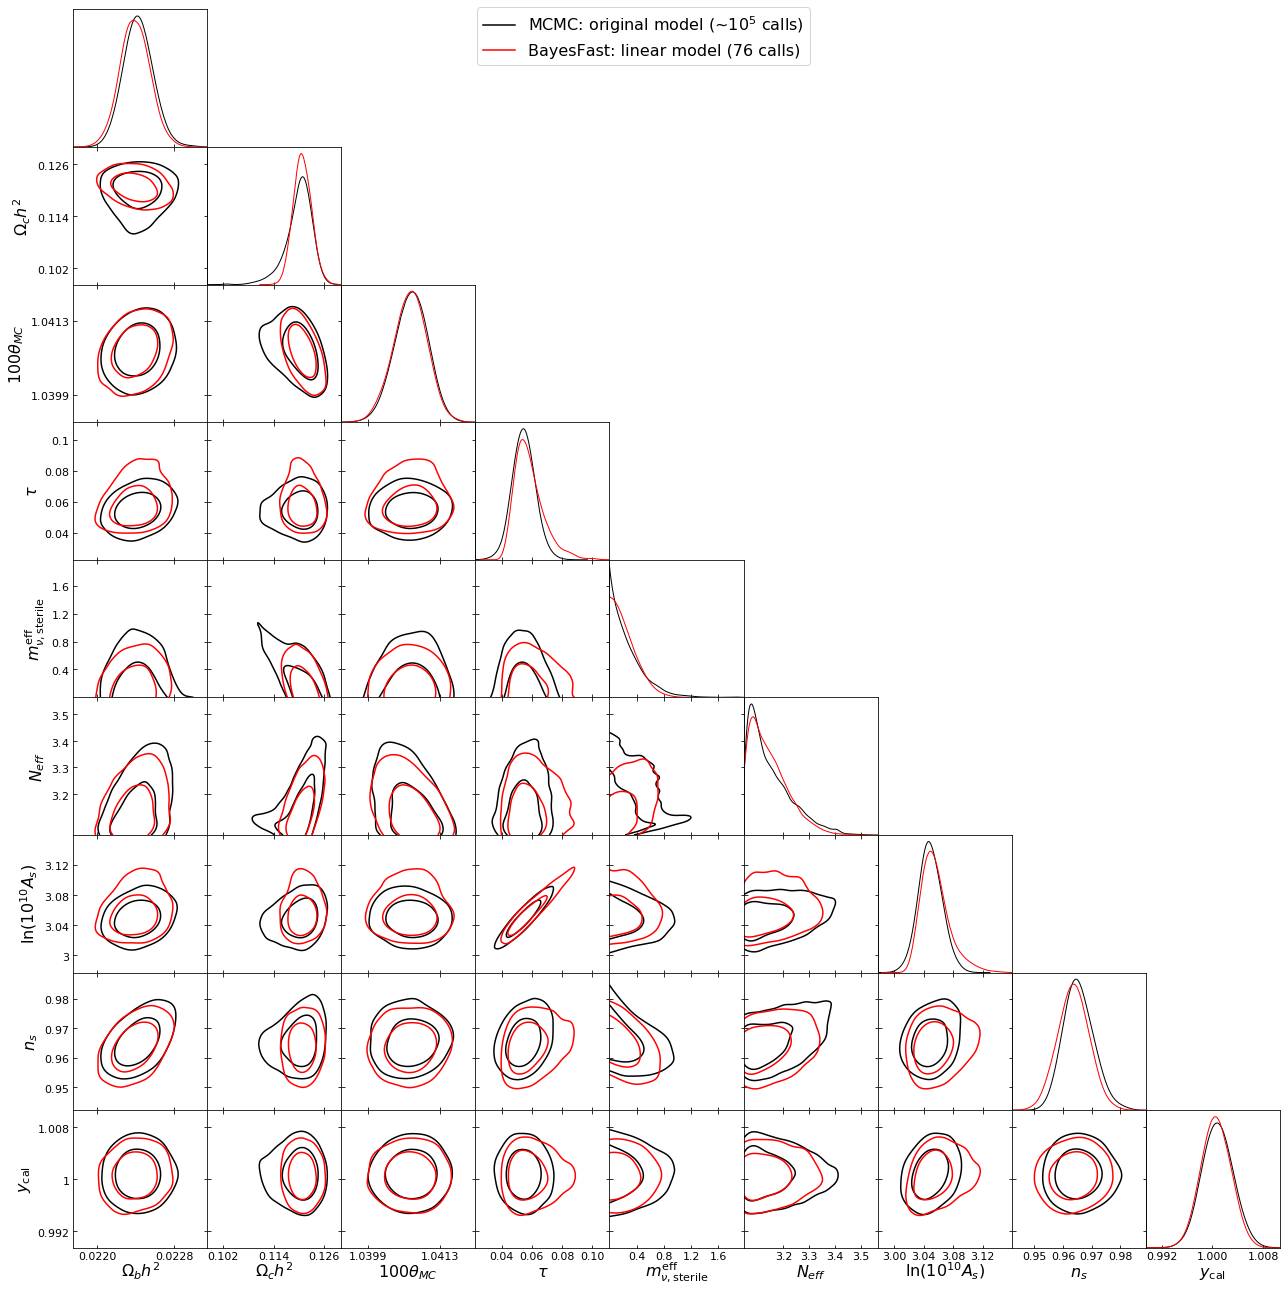

In [57]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(9)]
labels =  ['\\Omega_b h^2', '\\Omega_c h^2', '100\\theta_{MC}', '\\tau', 
           'm_{\\nu,{\\rm{sterile}}}^{\\rm{eff}}', 'N_{eff}', '{\\rm{ln}}(10^{10} A_s)', 'n_s', 'y_{\\rm cal}']
s_bf = MCSamples(samples=_xx_5, names=names, labels=labels, 
                 ranges=dict(zip(names, para_range)), label='BayesFast: linear model (76 calls)')
s_mcmc = MCSamples(samples=_x_mcmc, weights=_p_mcmc, names=names, labels=labels, 
                   ranges=dict(zip(names, para_range)), label='MCMC: original model (~$10^5$ calls)')
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 11
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 16
g.settings.lw_contour = 1.5
g.settings.lw1 = 1
g.triangle_plot([s_mcmc, s_bf], filled=False, contour_args={'alpha':1}, diag1d_kwargs={'normalized':True})
plt.show()

In [58]:
_ps_5 = np.concatenate([m2(m3(_[:-1]), _[-1], _[:-1]) for _ in _xx_5])
_i_5 = stratified_resample_1(_ps_5, 90)
xx_5 = _xx_5[_i_5]
ps_5 = _ps_5[_i_5]

In [59]:
import sharedmem
with sharedmem.MapReduce(np=18) as pool:
    yy_5 = np.array(pool.map(bnm_model, xx_5))

In [60]:
pt_5 = np.concatenate([m2(yy_5[i], xx_5[i][-1], xx_5[i][:-1]) for i in range(90)])
np.mean((pt_5 - ps_5)**2)

2.513058809879328

In [61]:
np.sum(pt_5 > np.min(ps_5))

86

In [62]:
m4 = PolyModel([PolyConfig('linear', np.arange(8), np.arange(669)),
                PolyConfig('quad', np.arange(8), np.arange(669))], 
                SurrogateIndices(0, 1), 8, 669, 
                input_names=['cosmology'], output_names=['power'])

In [63]:
den2 = Density('logp', [m1, m2], ['cosmology', 'cal'], [8, 1], m4, para_range,
               True, True)

In [64]:
m4.fit(xx_5[pt_5 > np.min(ps_5), :8].copy(), yy_5[pt_5 > np.min(ps_5)].copy())

In [65]:
m4.set_bound(xx_5[pt_5 > np.min(ps_5), :8].copy(), mu_f=xx_5[np.argmax(pt_5), :8], alpha_p=99)

In [66]:
cov_5 = np.cov(den2.from_original(_xx_5.copy()), rowvar=False)

In [67]:
nuts = [NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, True, False)),
            x_0=den2.from_original(xx_5[0]), random_state=np.random.RandomState(0), 
            metric=np.diag(cov_5), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, True, False)),
            x_0=den2.from_original(xx_5[1]), random_state=np.random.RandomState(1), 
            metric=np.diag(cov_5), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, True, False)),
            x_0=den2.from_original(xx_5[2]), random_state=np.random.RandomState(2), 
            metric=np.diag(cov_5), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, True, False)),
            x_0=den2.from_original(xx_5[3]), random_state=np.random.RandomState(3), 
            metric=np.diag(cov_5), step_size=1., target_accept=0.8)]
def worker(i):
    import bayesfast.utils.warnings as bfwarnings
    import warnings
    warnings.showwarning = bfwarnings.showwarning_chain(i)
    warnings.formatwarning = bfwarnings.formatwarning_chain(i)
    return nuts[i].run(3000, 1000)
import multiprocessing as mp
with mp.Pool(4) as pool:
    tt_5 = pool.map(worker, [0, 1, 2, 3])

CHAIN #1: sampling proceeding [ 300 / 3000 ], last 300 samples used 11.35 seconds, while divergence encountered in 54 sample(s). (warmup)
CHAIN #0: sampling proceeding [ 300 / 3000 ], last 300 samples used 12.13 seconds, while divergence encountered in 34 sample(s). (warmup)
CHAIN #2: sampling proceeding [ 300 / 3000 ], last 300 samples used 13.34 seconds, while divergence encountered in 42 sample(s). (warmup)
CHAIN #3: sampling proceeding [ 300 / 3000 ], last 300 samples used 13.56 seconds, while divergence encountered in 40 sample(s). (warmup)
CHAIN #1: sampling proceeding [ 600 / 3000 ], last 300 samples used 10.29 seconds, while divergence encountered in 30 sample(s). (warmup)
CHAIN #0: sampling proceeding [ 600 / 3000 ], last 300 samples used 9.67 seconds, while divergence encountered in 48 sample(s). (warmup)
CHAIN #2: sampling proceeding [ 600 / 3000 ], last 300 samples used 9.55 seconds, while divergence encountered in 32 sample(s). (warmup)
CHAIN #3: sampling proceeding [ 600 

In [68]:
_xx_6 = np.concatenate([den2.to_original(np.array(tt_5[_].samples[1001:])) for _ in range(4)])

In [69]:
from bayesfast.utils.acor import integrated_time
integrated_time(_xx_6.reshape((4, -1, 9)))

array([2.12974248, 5.78472541, 2.30307687, 3.49023966, 4.96592848,
       2.76671054, 3.25626931, 1.88464185, 1.86707845])

Removed no burn in
Removed no burn in


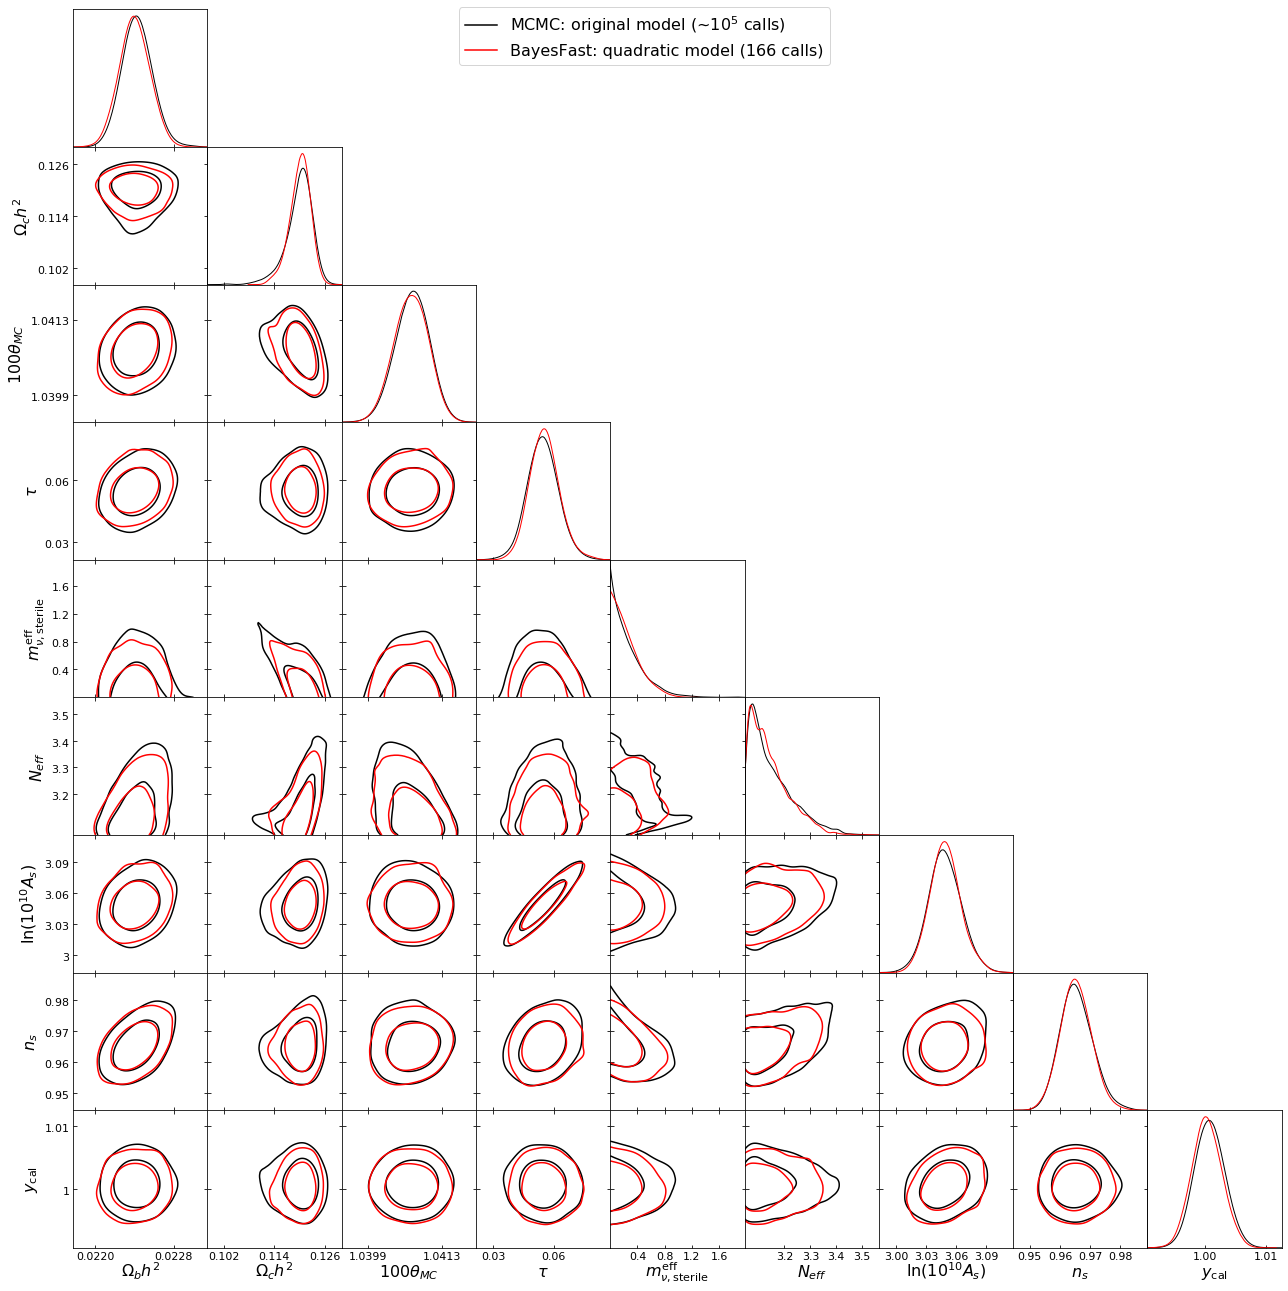

In [70]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(9)]
labels =  ['\\Omega_b h^2', '\\Omega_c h^2', '100\\theta_{MC}', '\\tau', 
           'm_{\\nu,{\\rm{sterile}}}^{\\rm{eff}}', 'N_{eff}', '{\\rm{ln}}(10^{10} A_s)', 'n_s', 'y_{\\rm cal}']
s_bf = MCSamples(samples=_xx_6, names=names, labels=labels, 
                 ranges=dict(zip(names, para_range)), label='BayesFast: quadratic model (166 calls)')
s_mcmc = MCSamples(samples=_x_mcmc, weights=_p_mcmc, names=names, labels=labels, 
                   ranges=dict(zip(names, para_range)), label='MCMC: original model (~$10^5$ calls)')
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 11
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 16
g.settings.lw_contour = 1.5
g.settings.lw1 = 1
g.triangle_plot([s_mcmc, s_bf], filled=False, contour_args={'alpha':1}, diag1d_kwargs={'normalized':True})
plt.show()

In [71]:
_ps_6 = np.concatenate([m2(m4(_[:-1]), _[-1], _[:-1]) for _ in _xx_6])
_i_6 = stratified_resample_2(_ps_6, 90)
xx_6 = _xx_6[_i_6]
ps_6 = _ps_6[_i_6]

In [72]:
import sharedmem
with sharedmem.MapReduce(np=18) as pool:
    yy_6 = np.array(pool.map(bnm_model, xx_6))

In [73]:
pt_6 = np.concatenate([m2(yy_6[i], xx_6[i][-1], xx_6[i][:-1]) for i in range(90)])
np.mean((pt_6 - ps_6)**2)

0.8471854709741632

In [74]:
xx_6c = np.concatenate((xx_5[pt_5 > np.min(ps_6)], 
                        xx_6[pt_6 > np.min(ps_6)]))
yy_6c = np.concatenate((yy_5[pt_5 > np.min(ps_6)], 
                        yy_6[pt_6 > np.min(ps_6)]))
pt_6c = np.concatenate((pt_5[pt_5 > np.min(ps_6)], 
                        pt_6[pt_6 > np.min(ps_6)]))
ps_6c = np.concatenate((ps_5[pt_5 > np.min(ps_6)], 
                        ps_6[pt_6 > np.min(ps_6)]))

In [75]:
np.sum(pt_5 > np.min(ps_6)), np.sum(pt_6 > np.min(ps_6))

(86, 88)

In [76]:
m4.fit(xx_6c[:, :8].copy(), yy_6c.copy())

In [77]:
m4.set_bound(xx_6c[:, :8].copy(), mu_f=xx_6c[np.argmax(pt_6c), :8], alpha_p=95)

In [78]:
cov_6 = np.cov(den2.from_original(_xx_6.copy()), rowvar=False)

In [79]:
nuts = [NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, True, False)),
            x_0=den2.from_original(xx_6[0]), random_state=np.random.RandomState(0), 
            metric=np.diag(cov_6), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, True, False)),
            x_0=den2.from_original(xx_6[1]), random_state=np.random.RandomState(1), 
            metric=np.diag(cov_6), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, True, False)),
            x_0=den2.from_original(xx_6[2]), random_state=np.random.RandomState(2), 
            metric=np.diag(cov_6), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, True, False)),
            x_0=den2.from_original(xx_6[3]), random_state=np.random.RandomState(3), 
            metric=np.diag(cov_6), step_size=1., target_accept=0.8)]
def worker(i):
    import bayesfast.utils.warnings as bfwarnings
    import warnings
    warnings.showwarning = bfwarnings.showwarning_chain(i)
    warnings.formatwarning = bfwarnings.formatwarning_chain(i)
    return nuts[i].run(3000, 1000)
import multiprocessing as mp
with mp.Pool(4) as pool:
    tt_6 = pool.map(worker, [0, 1, 2, 3])

/global/homes/h/hejia/.conda/envs/hejia@cori-2/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning from CHAIN #1: divide by zero encountered in double_scalars


CHAIN #1: sampling proceeding [ 300 / 3000 ], last 300 samples used 10.82 seconds, while divergence encountered in 49 sample(s). (warmup)
CHAIN #0: sampling proceeding [ 300 / 3000 ], last 300 samples used 11.08 seconds, while divergence encountered in 30 sample(s). (warmup)
CHAIN #3: sampling proceeding [ 300 / 3000 ], last 300 samples used 11.91 seconds, while divergence encountered in 37 sample(s). (warmup)
CHAIN #2: sampling proceeding [ 300 / 3000 ], last 300 samples used 12.09 seconds, while divergence encountered in 40 sample(s). (warmup)
CHAIN #1: sampling proceeding [ 600 / 3000 ], last 300 samples used 8.03 seconds, while divergence encountered in 38 sample(s). (warmup)
CHAIN #0: sampling proceeding [ 600 / 3000 ], last 300 samples used 9.08 seconds, while divergence encountered in 29 sample(s). (warmup)
CHAIN #3: sampling proceeding [ 600 / 3000 ], last 300 samples used 8.90 seconds, while divergence encountered in 35 sample(s). (warmup)
CHAIN #2: sampling proceeding [ 600 /

In [80]:
_xx_7 = np.concatenate([den2.to_original(np.array(tt_6[_].samples[1001:])) for _ in range(4)])

In [81]:
from bayesfast.utils.acor import integrated_time
integrated_time(_xx_7.reshape((4, -1, 9)))

array([1.93941891, 2.57101413, 2.03759892, 2.53838487, 2.19260997,
       2.79464677, 2.67689245, 2.10843295, 1.44078204])

Removed no burn in
Removed no burn in


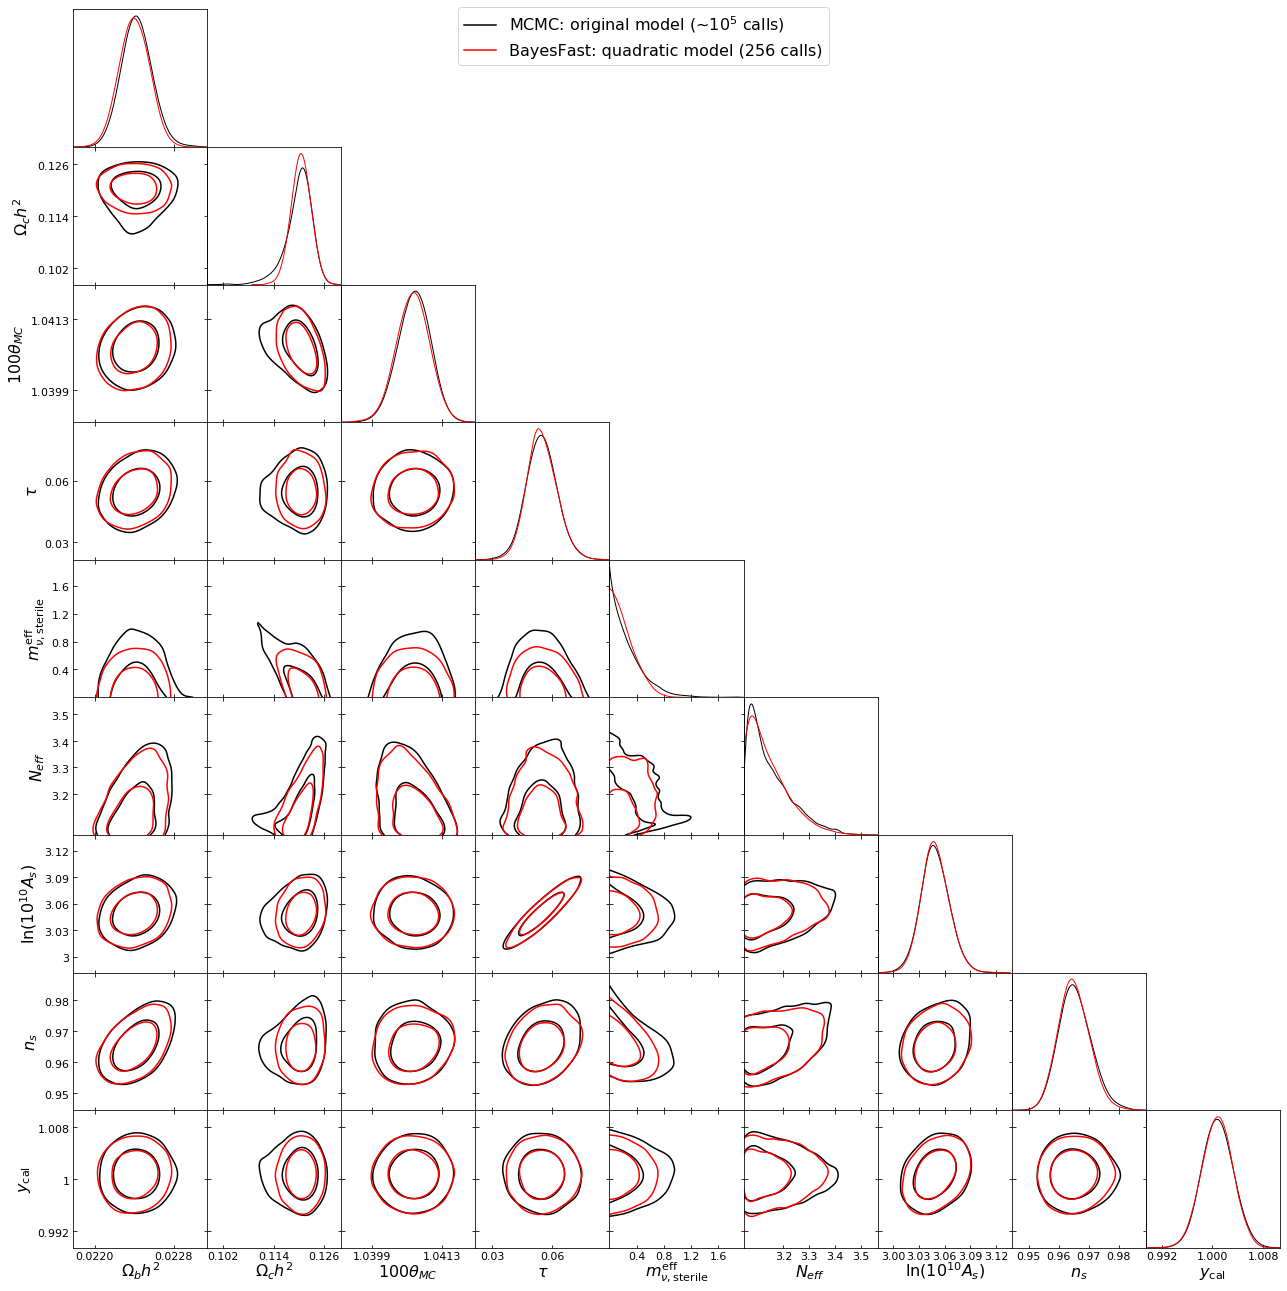

In [82]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(9)]
labels =  ['\\Omega_b h^2', '\\Omega_c h^2', '100\\theta_{MC}', '\\tau', 
           'm_{\\nu,{\\rm{sterile}}}^{\\rm{eff}}', 'N_{eff}', '{\\rm{ln}}(10^{10} A_s)', 'n_s', 'y_{\\rm cal}']
s_bf = MCSamples(samples=_xx_7, names=names, labels=labels, 
                 ranges=dict(zip(names, para_range)), label='BayesFast: quadratic model (256 calls)')
s_mcmc = MCSamples(samples=_x_mcmc, weights=_p_mcmc, names=names, labels=labels, 
                   ranges=dict(zip(names, para_range)), label='MCMC: original model (~$10^5$ calls)')
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 11
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 16
g.settings.lw_contour = 1.5
g.settings.lw1 = 1
g.triangle_plot([s_mcmc, s_bf], filled=False, contour_args={'alpha':1}, diag1d_kwargs={'normalized':True})
plt.show()

In [83]:
_ps_7 = np.concatenate([m2(m4(_[:-1]), _[-1], _[:-1]) for _ in _xx_7])
_i_7 = stratified_resample_2(_ps_7, 90)
xx_7 = _xx_7[_i_7]
ps_7 = _ps_7[_i_7]

In [84]:
import sharedmem
with sharedmem.MapReduce(np=18) as pool:
    yy_7 = np.array(pool.map(bnm_model, xx_7))

In [85]:
pt_7 = np.concatenate([m2(yy_7[i], xx_7[i][-1], xx_7[i][:-1]) for i in range(90)])
np.mean((pt_7 - ps_7)**2)

0.3515527643900216

In [86]:
xx_7c = np.concatenate((xx_5[pt_5 > np.min(ps_7)], 
                        xx_6[pt_6 > np.min(ps_7)], 
                        xx_7[pt_7 > np.min(ps_7)]))
yy_7c = np.concatenate((yy_5[pt_5 > np.min(ps_7)], 
                        yy_6[pt_6 > np.min(ps_7)], 
                        yy_7[pt_7 > np.min(ps_7)]))
pt_7c = np.concatenate((pt_5[pt_5 > np.min(ps_7)], 
                        pt_6[pt_6 > np.min(ps_7)], 
                        pt_7[pt_7 > np.min(ps_7)]))
ps_7c = np.concatenate((ps_5[pt_5 > np.min(ps_7)], 
                        ps_6[pt_6 > np.min(ps_7)], 
                        ps_7[pt_7 > np.min(ps_7)]))

In [87]:
m5 = PolyModel([PolyConfig('linear', np.arange(8), np.arange(669)),
                PolyConfig('quad', np.arange(8), np.arange(669)),
                PolyConfig('cubic_2', np.arange(8), np.arange(669)),
               ], 
                SurrogateIndices(0, 1), 8, 669, 
                input_names=['cosmology'], output_names=['power'])

In [88]:
den3 = Density('logp', [m1, m2], ['cosmology', 'cal'], [8, 1], m5, para_range,
               True, True)

In [89]:
m5.fit(xx_7c[:, :8].copy(), yy_7c)

In [90]:
m5.set_bound(xx_7c[:, :8].copy(), mu_f=xx_7c[np.argmax(pt_7c), :8], alpha_p=95)

In [91]:
cov_7 = np.cov(den3.from_original(_xx_7.copy()), rowvar=False)

In [92]:
nuts = [NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den3.logp_and_grad(xx, True, False)),
            x_0=den3.from_original(xx_7[0]), random_state=np.random.RandomState(0), 
            metric=np.diag(cov_7), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den3.logp_and_grad(xx, True, False)),
            x_0=den3.from_original(xx_7[1]), random_state=np.random.RandomState(1), 
            metric=np.diag(cov_7), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den3.logp_and_grad(xx, True, False)),
            x_0=den3.from_original(xx_7[2]), random_state=np.random.RandomState(2), 
            metric=np.diag(cov_7), step_size=1., target_accept=0.8),
        NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den3.logp_and_grad(xx, True, False)),
            x_0=den3.from_original(xx_7[3]), random_state=np.random.RandomState(3), 
            metric=np.diag(cov_7), step_size=1., target_accept=0.8)]
def worker(i):
    import bayesfast.utils.warnings as bfwarnings
    import warnings
    warnings.showwarning = bfwarnings.showwarning_chain(i)
    warnings.formatwarning = bfwarnings.formatwarning_chain(i)
    return nuts[i].run(5000, 1000)
import multiprocessing as mp
with mp.Pool(4) as pool:
    tt_7 = pool.map(worker, [0, 1, 2, 3])

CHAIN #3: sampling proceeding [ 500 / 5000 ], last 500 samples used 21.69 seconds, while divergence encountered in 77 sample(s). (warmup)
CHAIN #1: sampling proceeding [ 500 / 5000 ], last 500 samples used 23.90 seconds, while divergence encountered in 75 sample(s). (warmup)
CHAIN #0: sampling proceeding [ 500 / 5000 ], last 500 samples used 25.24 seconds, while divergence encountered in 70 sample(s). (warmup)
CHAIN #2: sampling proceeding [ 500 / 5000 ], last 500 samples used 26.54 seconds, while divergence encountered in 70 sample(s). (warmup)
CHAIN #3: sampling proceeding [ 1000 / 5000 ], last 500 samples used 20.27 seconds, while divergence encountered in 79 sample(s). (warmup)
CHAIN #1: sampling proceeding [ 1000 / 5000 ], last 500 samples used 20.16 seconds, while divergence encountered in 64 sample(s). (warmup)
CHAIN #2: sampling proceeding [ 1000 / 5000 ], last 500 samples used 20.00 seconds, while divergence encountered in 70 sample(s). (warmup)
CHAIN #0: sampling proceeding [

In [93]:
_xx_8 = np.concatenate([den2.to_original(np.array(tt_7[_].samples[1001:])) for _ in range(4)])

In [94]:
from bayesfast.utils.acor import integrated_time
integrated_time(_xx_8.reshape((4, -1, 9)))

array([2.39230002, 4.3091763 , 2.23506385, 2.91784013, 3.07194267,
       3.18985313, 3.05881788, 2.54834595, 1.7257382 ])

Removed no burn in
Removed no burn in


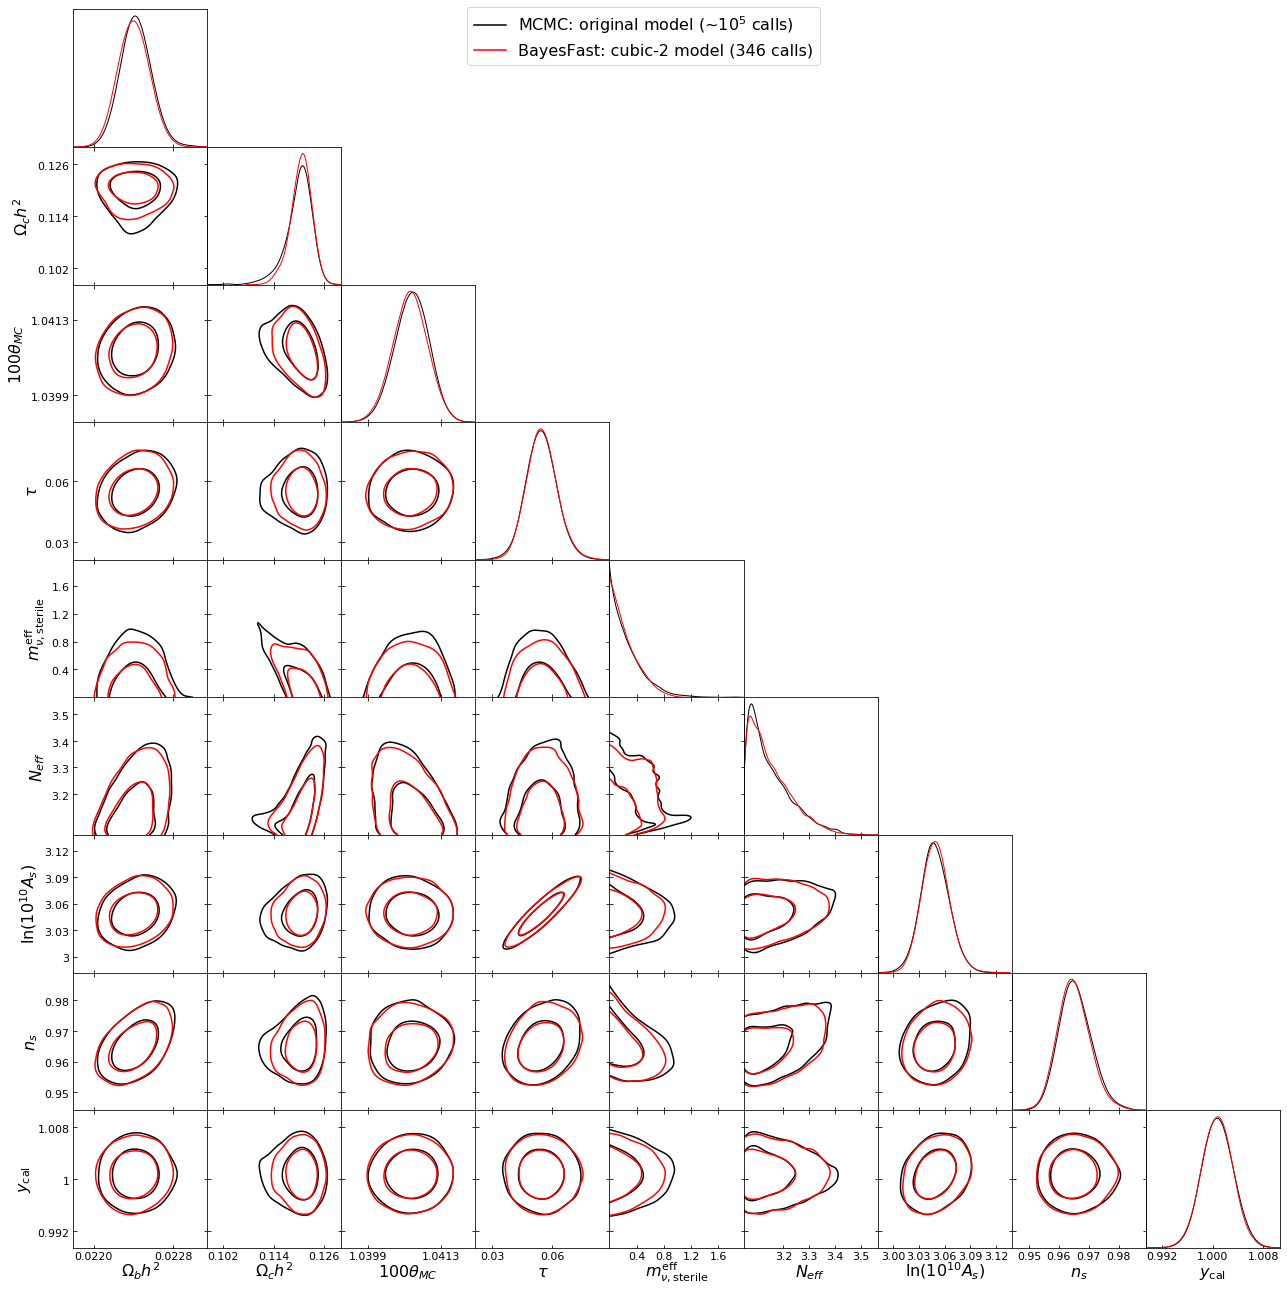

In [95]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(9)]
labels =  ['\\Omega_b h^2', '\\Omega_c h^2', '100\\theta_{MC}', '\\tau', 
           'm_{\\nu,{\\rm{sterile}}}^{\\rm{eff}}', 'N_{eff}', '{\\rm{ln}}(10^{10} A_s)', 'n_s', 'y_{\\rm cal}']
s_bf = MCSamples(samples=_xx_8, names=names, labels=labels, 
                 ranges=dict(zip(names, para_range)), label='BayesFast: cubic-2 model (346 calls)')
s_mcmc = MCSamples(samples=_x_mcmc, weights=_p_mcmc, names=names, labels=labels, 
                   ranges=dict(zip(names, para_range)), label='MCMC: original model (~$10^5$ calls)')
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 11
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 16
g.settings.lw_contour = 1.5
g.settings.lw1 = 1
g.triangle_plot([s_mcmc, s_bf], filled=False, contour_args={'alpha':1}, diag1d_kwargs={'normalized':True})
plt.show()

In [96]:
_ps_8 = np.concatenate([m2(m5(_[:-1]), _[-1], _[:-1]) for _ in _xx_8])

In [ ]:
################################################################################

In [97]:
np.save('ttteee/0/_xx_8.npy', _xx_8)
np.save('ttteee/0/_ps_8.npy', _ps_8)

In [ ]:
################################################################################

In [ ]:
################################################################################

Removed no burn in
Removed no burn in


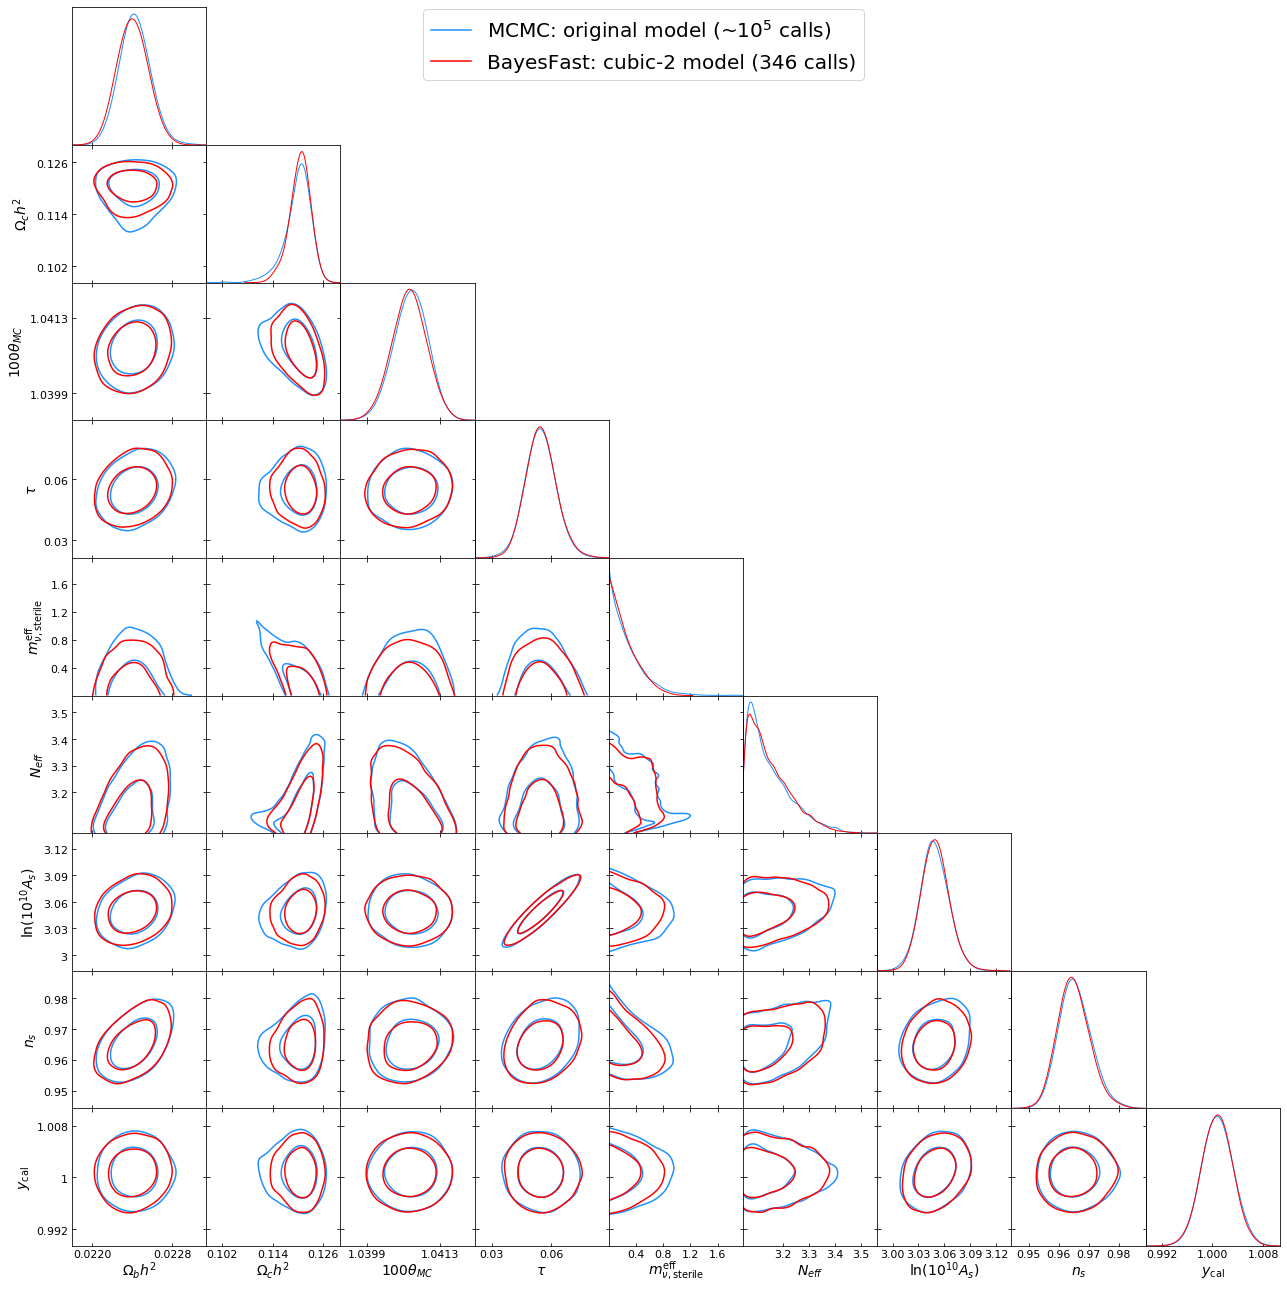

In [99]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(9)]
labels =  ['\\Omega_b h^2', '\\Omega_c h^2', '100\\theta_{MC}', '\\tau', 
           'm_{\\nu,{\\rm{sterile}}}^{\\rm{eff}}', 'N_{eff}', '{\\rm{ln}}(10^{10} A_s)', 'n_s', 'y_{\\rm cal}']
s_bf = MCSamples(samples=_xx_8, names=names, labels=labels, 
                 ranges=dict(zip(names, para_range)), label='BayesFast: cubic-2 model (346 calls)')
s_mcmc = MCSamples(samples=_x_mcmc, weights=_p_mcmc, names=names, labels=labels, 
                   ranges=dict(zip(names, para_range)), label='MCMC: original model (~$10^5$ calls)')
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 11
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 20
g.settings.legend_loc = 'upper right'
g.settings.lw_contour = 1.5
g.settings.lw1 = 1
g.triangle_plot([s_mcmc, s_bf], filled=False, contour_args={'alpha':1}, 
                diag1d_kwargs={'normalized':True}, contour_colors=['dodgerblue', 
                'red'])
plt.savefig('ttteee-0.pdf')
plt.show()